In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [2]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis=1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis=1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


In [5]:
train['X4'].unique()

array([22.5, 13. , 18. , 15. , 14.5, 14. , 21. , 19.5, 19. , 20.5, 16. ,
       20. , 25. , 13.5, 11. , 12. , 28. , 30. , 15.5, 17. , 10. , 22. ,
       21.5, 23. , 15.1, 34. , 27. , 18.5, 26. , 26.5, 12.5, 17.5, 24. ,
       36. , 25.5, 23.5, 16.5,  9. ,  6. , 24.5, 32. ,  8.1, 35. , 10.5,
       11.5,  7.1, 31. ,  7. ,  8. ,  9.5, 35.5, 28.5, 34.5, 27.5, 33. ,
       29.5, 29. , 30.5, 20.1, 32.5, 33.5, 31.5, 40. ])

# 특징 만들기


In [6]:
# train['X8'] = train['X8'].str.extract(r'(PL|PS)')
# test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [7]:
# train['X8_encoded'] = (train['X8'] != 'PL').astype(int)
# test['X8_encoded'] = (test['X8'] != 'PL').astype(int)

# train = pd.get_dummies(train, columns=['X8_encoded'], prefix=['X8'])
# test = pd.get_dummies(test, columns=['X8_encoded'], prefix=['X8'])

# train[['X8_0', 'X8_1']] = train[['X8_0', 'X8_1']].astype(int)
# test[['X8_0', 'X8_1']] = test[['X8_0', 'X8_1']].astype(int)

In [8]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

In [9]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

train.drop(columns = ['X5'], inplace = True)
test.drop(columns = ['X5'], inplace = True)

In [10]:
# def estimate_rotation_speed(X2, X3, X4, X5_numeric, X6):
#     rotation_speed = X2 + (X3 / X4) * (X5_numeric / 10) * (X6 / 2)
#     return rotation_speed

# train['Estimated_Rotation_Speed'] = estimate_rotation_speed(train['X2'], train['X3'], train['X4'], train['X5_numeric'], train['X6'])
# test['Estimated_Rotation_Speed'] = estimate_rotation_speed(test['X2'], test['X3'], test['X4'], test['X5_numeric'], test['X6'])

In [11]:
train['X2/X3'] = train['X2'] / train['X3']
test['X2/X3'] = test['X2'] / test['X3']

In [12]:
train['SPT'] = train['X5_numeric'] / train['X4']
test['SPT'] = test['X5_numeric'] / test['X4']

In [13]:
train['SPTCC'] = train['SPT'] * train['X6']
test['SPTCC'] = test['SPT'] * test['X6']

In [14]:
X2_idx = train[(train['X2'] > 440)].index # 440
X3_idx = train[(train['X3'] > 550)].index # 550
X4_idx = train[(train['X4'] > 36)].index
X6_idx = train[(train['X6'] > 250)].index # 250
Y1_idx = train[(train['Y1'] == 0) | (train['Y1'] > 70000)].index
Y2_idx = train[(train['Y2'] == 0) | (train['Y2'] > 70000)].index

train.loc[X2_idx, 'X2'] = train.loc[(train ['X2'] >= 500), 'X2'].mean()
train.loc[X3_idx, 'X3'] = train.loc[(train ['X3'] >= 600), 'X3'].mean()
train.loc[X4_idx, 'X4'] = train.loc[(train ['X4'] >= 36), 'X4'].mean()
train.loc[X6_idx, 'X6'] = train.loc[(train ['X6'] >= 265), 'X6'].mean()
train.loc[Y1_idx, 'Y1'] = train.loc[(train['Y1'] != 0) & (train['Y1'] <= 70000), 'Y1'].mean()
train.loc[Y2_idx, 'Y2'] = train.loc[(train['Y2'] != 0) & (train['Y2'] <= 70000), 'Y2'].mean()

# train = train[(train['X2'] <= 440) & (train['X3'] <= 550) & (train['X4'] <= 36) & (train['X6'] <= 250)]
# train.loc[train['Y1'] == 0, 'Y1'] = train.loc[train['Y1'] != 0, 'Y1'].mean()
# train.loc[train['Y2'] == 0, 'Y2'] = train.loc[train['Y2'] != 0, 'Y2'].mean()
# train = train[(train['Y1'] != 0) & (train['Y1'] <= 70000)]
# train = train[(train['Y2'] != 0) & (train['Y2'] <= 70000)]

In [15]:
scaler = MinMaxScaler()

columns_to_scale = ['X2', 'X3', 'X4', 'X6', 'X2/X3']

train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [16]:
# columns_to_dbscan = ['X2', 'X3', 'X4', 'X6', 'X2/X3', 'X5_numeric', 'Estimated_Rotation_Speed']

# dbscan = DBSCAN(eps=5, min_samples=5)
# train['cluster'] = dbscan.fit_predict(train[columns_to_dbscan])

# # 클러스터가 -1인 것은 이상치로 간주하고 제거
# train = train[train['cluster'] != -1].drop(columns=['cluster'])

# train

In [17]:
train

,X2,X3,X4,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,X2/X3,SPT,SPTCC
0,0.103873,0.106535,0.549686,0.008772,97,PL973,467.0,2241.0,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069,313.6,0.009845,13.937778,55.751111
1,0.218701,0.105724,0.233200,0.002924,27,PL271,1058.0,1163.0,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,0.020675,24.123077,48.246154
2,0.109546,0.069402,0.399772,0.000000,14,PL141,270.0,1094.0,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690,313.6,0.015900,17.422222,17.422222
3,0.095657,0.155019,0.299829,0.046784,24,PL242,391.0,2604.0,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657,235.0,0.006173,15.666667,266.333333
4,0.077660,0.092265,0.283172,0.008772,23,PL233,232.0,1564.0,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.008578,16.206897,64.827586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,0.186228,0.142209,0.133257,0.020468,21,PS213,906.0,1226.0,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671,235.0,0.013102,23.500000,188.000000
121750,0.087637,0.079779,0.566343,0.000000,23,PL231,175.0,1540.0,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385,352.8,0.011159,15.339130,15.339130
121751,0.076878,0.046052,0.932801,0.011696,27,PL272,376.0,1492.0,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574,352.8,0.016881,10.376471,51.882353
121752,0.036972,0.021891,0.999429,0.020468,97,PL973,85.0,723.0,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069,352.8,0.017337,9.800000,78.400000


In [18]:
# exclude_columns = ['cluster']

# num_columns = len(filtered_train.columns) - len(exclude_columns)
# num_rows = (num_columns - 1) // 4 + 1 

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows * 4))
# axes = axes.flatten()

# index = 0
# for i, column in enumerate(filtered_train.columns):
#     if column not in exclude_columns:
#         sns.histplot(data=filtered_train, x=column, kde=True, ax=axes[index])
#         axes[index].set_title(f'Histogram of {column}')
#         axes[index].set_xlabel('Values')
#         axes[index].set_ylabel('Frequency')
#         index += 1

# for i in range(index, len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()  
# plt.show()

In [19]:
train['Y1'] = np.log1p(train['Y1'])
train['Y2'] = np.log1p(train['Y2'])

<Axes: >

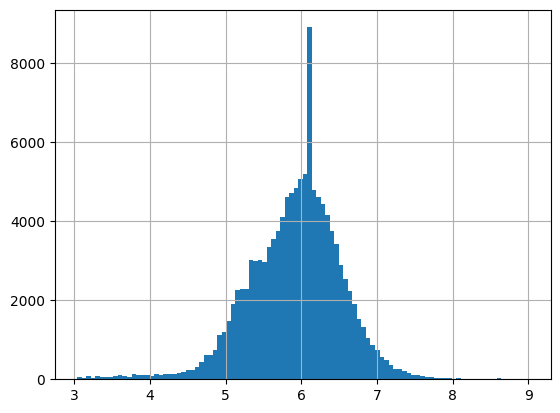

In [20]:
train = train[(train['Y1'] > 3) & (train['Y1'] < 9)]
train['Y1'].hist(bins=100)

<Axes: >

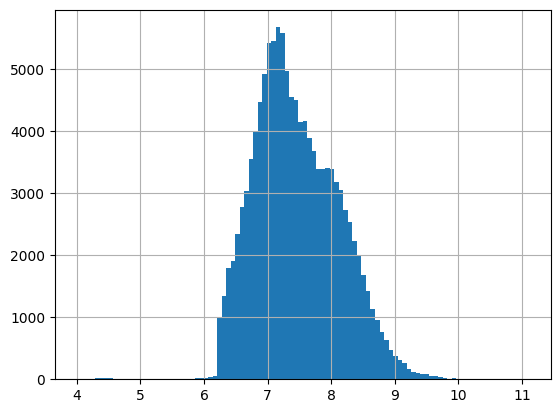

In [21]:
train = train[(train['Y2'] > 4) & (train['Y1'] < 10)]
train['Y2'].hist(bins=100)

## CatBoost

In [22]:
cat_y1 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y1.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    cat_pred = cat_y1.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4613840	test: 0.4621797	best: 0.4621797 (0)	total: 202ms	remaining: 3m 21s
50:	learn: 0.2535773	test: 0.2537369	best: 0.2537369 (50)	total: 3.57s	remaining: 1m 6s
100:	learn: 0.2142218	test: 0.2145207	best: 0.2145207 (100)	total: 7.19s	remaining: 1m 3s
150:	learn: 0.2023273	test: 0.2028362	best: 0.2028362 (150)	total: 10.4s	remaining: 58.6s
200:	learn: 0.1971827	test: 0.1979566	best: 0.1979566 (200)	total: 13.3s	remaining: 52.8s
250:	learn: 0.1940966	test: 0.1950652	best: 0.1950652 (250)	total: 16.3s	remaining: 48.6s
300:	learn: 0.1919222	test: 0.1930819	best: 0.1930819 (300)	total: 19.5s	remaining: 45.2s
350:	learn: 0.1902148	test: 0.1915578	best: 0.1915578 (350)	total: 22.9s	remaining: 42.3s
400:	learn: 0.1888863	test: 0.1903839	best: 0.1903839 (400)	total: 26.2s	remaining: 39.1s
450:	learn: 0.1877296	test: 0.1893625	best: 0.1893625 (450)	total: 29.4s	remaining: 35.7s
500:	learn: 0.1866500	test: 0.1884726	best: 0.1884726 (500)	total: 32.4s	remaining: 32.3s
550:	learn: 0.1

Processing folds:  20%|██        | 1/5 [01:05<04:20, 65.08s/it]

999:	learn: 0.1801894	test: 0.1835658	best: 0.1835658 (999)	total: 1m 4s	remaining: 0us

bestTest = 0.1835657632
bestIteration = 999

0:	learn: 0.4612282	test: 0.4629526	best: 0.4629526 (0)	total: 84.9ms	remaining: 1m 24s
50:	learn: 0.2531601	test: 0.2565337	best: 0.2565337 (50)	total: 3.4s	remaining: 1m 3s
100:	learn: 0.2135514	test: 0.2166637	best: 0.2166637 (100)	total: 6.59s	remaining: 58.7s
150:	learn: 0.2019443	test: 0.2051043	best: 0.2051043 (150)	total: 9.75s	remaining: 54.8s
200:	learn: 0.1967883	test: 0.2000051	best: 0.2000051 (200)	total: 12.8s	remaining: 50.9s
250:	learn: 0.1937388	test: 0.1970542	best: 0.1970542 (250)	total: 15.9s	remaining: 47.5s
300:	learn: 0.1916181	test: 0.1950020	best: 0.1950020 (300)	total: 19.1s	remaining: 44.3s
350:	learn: 0.1898957	test: 0.1933239	best: 0.1933239 (350)	total: 22.1s	remaining: 40.9s
400:	learn: 0.1885285	test: 0.1920524	best: 0.1920524 (400)	total: 25.1s	remaining: 37.6s
450:	learn: 0.1872357	test: 0.1908450	best: 0.1908450 (450)	t

Processing folds:  40%|████      | 2/5 [02:07<03:10, 63.59s/it]

999:	learn: 0.1796941	test: 0.1847672	best: 0.1847672 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.1847672485
bestIteration = 999

0:	learn: 0.4612777	test: 0.4624550	best: 0.4624550 (0)	total: 67.8ms	remaining: 1m 7s
50:	learn: 0.2535039	test: 0.2553922	best: 0.2553922 (50)	total: 3.12s	remaining: 58.1s
100:	learn: 0.2136936	test: 0.2164662	best: 0.2164662 (100)	total: 6.19s	remaining: 55.1s
150:	learn: 0.2018432	test: 0.2047445	best: 0.2047445 (150)	total: 9.13s	remaining: 51.3s
200:	learn: 0.1968479	test: 0.1997780	best: 0.1997780 (200)	total: 12s	remaining: 47.9s
250:	learn: 0.1938864	test: 0.1968906	best: 0.1968906 (250)	total: 15s	remaining: 44.7s
300:	learn: 0.1916899	test: 0.1947520	best: 0.1947520 (300)	total: 17.9s	remaining: 41.6s
350:	learn: 0.1901655	test: 0.1932435	best: 0.1932435 (350)	total: 20.8s	remaining: 38.5s
400:	learn: 0.1887771	test: 0.1918734	best: 0.1918734 (400)	total: 23.8s	remaining: 35.5s
450:	learn: 0.1876028	test: 0.1907897	best: 0.1907897 (450)	total

Processing folds:  60%|██████    | 3/5 [03:07<02:03, 61.74s/it]

999:	learn: 0.1801855	test: 0.1848391	best: 0.1848391 (999)	total: 59.1s	remaining: 0us

bestTest = 0.1848391082
bestIteration = 999

0:	learn: 0.4612124	test: 0.4626177	best: 0.4626177 (0)	total: 67ms	remaining: 1m 6s
50:	learn: 0.2536723	test: 0.2534869	best: 0.2534869 (50)	total: 3.14s	remaining: 58.5s
100:	learn: 0.2143694	test: 0.2136258	best: 0.2136258 (100)	total: 6.21s	remaining: 55.3s
150:	learn: 0.2026758	test: 0.2020015	best: 0.2020015 (150)	total: 9.16s	remaining: 51.5s
200:	learn: 0.1974550	test: 0.1970352	best: 0.1970352 (200)	total: 12s	remaining: 47.8s
250:	learn: 0.1944121	test: 0.1941799	best: 0.1941799 (250)	total: 15s	remaining: 44.6s
300:	learn: 0.1922337	test: 0.1921564	best: 0.1921564 (300)	total: 18.6s	remaining: 43.1s
350:	learn: 0.1905885	test: 0.1906398	best: 0.1906398 (350)	total: 21.9s	remaining: 40.4s
400:	learn: 0.1891889	test: 0.1893428	best: 0.1893428 (400)	total: 25s	remaining: 37.3s
450:	learn: 0.1880157	test: 0.1882900	best: 0.1882900 (450)	total: 28

Processing folds:  80%|████████  | 4/5 [04:08<01:01, 61.74s/it]

999:	learn: 0.1805522	test: 0.1821984	best: 0.1821984 (999)	total: 1m 1s	remaining: 0us

bestTest = 0.1821984388
bestIteration = 999

0:	learn: 0.4623337	test: 0.4573452	best: 0.4573452 (0)	total: 71.9ms	remaining: 1m 11s
50:	learn: 0.2541668	test: 0.2496255	best: 0.2496255 (50)	total: 3.18s	remaining: 59.2s
100:	learn: 0.2149806	test: 0.2107739	best: 0.2107739 (100)	total: 6.43s	remaining: 57.2s
150:	learn: 0.2029768	test: 0.1992405	best: 0.1992405 (150)	total: 9.62s	remaining: 54.1s
200:	learn: 0.1979714	test: 0.1945910	best: 0.1945910 (200)	total: 12.8s	remaining: 50.7s
250:	learn: 0.1948822	test: 0.1917594	best: 0.1917594 (250)	total: 15.9s	remaining: 47.4s
300:	learn: 0.1928559	test: 0.1900030	best: 0.1900030 (300)	total: 18.9s	remaining: 43.9s
350:	learn: 0.1911147	test: 0.1885415	best: 0.1885415 (350)	total: 21.9s	remaining: 40.6s
400:	learn: 0.1897634	test: 0.1874150	best: 0.1874150 (400)	total: 25s	remaining: 37.4s
450:	learn: 0.1885871	test: 0.1864509	best: 0.1864509 (450)	to

Processing folds: 100%|██████████| 5/5 [05:11<00:00, 62.31s/it]

999:	learn: 0.1811498	test: 0.1807131	best: 0.1807131 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.1807130592
bestIteration = 999

Validation : MAE scores for each fold: [0.1835667625507939, 0.18476298701627256, 0.18483742298293163, 0.18218508746474063, 0.18072665599818655]
Validation : MAE: 0.18321578320258505


In [23]:
cat_y2 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y2.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    cat_pred = cat_y2.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5235002	test: 0.5234488	best: 0.5234488 (0)	total: 62.2ms	remaining: 1m 2s
50:	learn: 0.2093472	test: 0.2079778	best: 0.2079778 (50)	total: 3.23s	remaining: 1m
100:	learn: 0.1384588	test: 0.1368192	best: 0.1368192 (100)	total: 6.32s	remaining: 56.3s
150:	learn: 0.1162841	test: 0.1145770	best: 0.1145770 (150)	total: 9.4s	remaining: 52.8s
200:	learn: 0.1082987	test: 0.1065962	best: 0.1065962 (200)	total: 12.2s	remaining: 48.7s
250:	learn: 0.1042698	test: 0.1025489	best: 0.1025489 (250)	total: 15.2s	remaining: 45.3s
300:	learn: 0.1017406	test: 0.1000136	best: 0.1000136 (300)	total: 18.1s	remaining: 42.1s
350:	learn: 0.1000359	test: 0.0983361	best: 0.0983361 (350)	total: 21.1s	remaining: 39s
400:	learn: 0.0985828	test: 0.0969396	best: 0.0969396 (400)	total: 24.1s	remaining: 36s
450:	learn: 0.0974870	test: 0.0959141	best: 0.0959141 (450)	total: 27.2s	remaining: 33.1s
500:	learn: 0.0964958	test: 0.0949734	best: 0.0949734 (500)	total: 30.2s	remaining: 30.1s
550:	learn: 0.0955766	t

Processing folds:  20%|██        | 1/5 [01:00<04:02, 60.52s/it]

999:	learn: 0.0914499	test: 0.0904179	best: 0.0904179 (999)	total: 1m	remaining: 0us

bestTest = 0.09041794059
bestIteration = 999

0:	learn: 0.5233965	test: 0.5237843	best: 0.5237843 (0)	total: 82.5ms	remaining: 1m 22s
50:	learn: 0.2095809	test: 0.2117536	best: 0.2117536 (50)	total: 3.08s	remaining: 57.2s
100:	learn: 0.1376236	test: 0.1398457	best: 0.1398457 (100)	total: 6.1s	remaining: 54.3s
150:	learn: 0.1150557	test: 0.1170043	best: 0.1170043 (150)	total: 9.09s	remaining: 51.1s
200:	learn: 0.1072393	test: 0.1092221	best: 0.1092221 (200)	total: 12s	remaining: 47.7s
250:	learn: 0.1035598	test: 0.1055475	best: 0.1055475 (250)	total: 15s	remaining: 44.6s
300:	learn: 0.1008192	test: 0.1029097	best: 0.1029097 (300)	total: 18s	remaining: 41.7s
350:	learn: 0.0990287	test: 0.1012533	best: 0.1012533 (350)	total: 20.9s	remaining: 38.7s
400:	learn: 0.0976698	test: 0.0999967	best: 0.0999967 (400)	total: 23.9s	remaining: 35.7s
450:	learn: 0.0965149	test: 0.0988955	best: 0.0988955 (450)	total: 26

Processing folds:  40%|████      | 2/5 [02:00<03:00, 60.22s/it]

999:	learn: 0.0905453	test: 0.0935859	best: 0.0935859 (999)	total: 59.5s	remaining: 0us

bestTest = 0.09358591203
bestIteration = 999

0:	learn: 0.5238875	test: 0.5226348	best: 0.5226348 (0)	total: 59.9ms	remaining: 59.9s
50:	learn: 0.2075364	test: 0.2078949	best: 0.2078949 (50)	total: 3.08s	remaining: 57.4s
100:	learn: 0.1371792	test: 0.1376659	best: 0.1376659 (100)	total: 6.18s	remaining: 55s
150:	learn: 0.1155259	test: 0.1160284	best: 0.1160284 (150)	total: 9.18s	remaining: 51.6s
200:	learn: 0.1077936	test: 0.1083221	best: 0.1083221 (200)	total: 12.1s	remaining: 48.2s
250:	learn: 0.1036202	test: 0.1043049	best: 0.1043049 (250)	total: 15.1s	remaining: 45.2s
300:	learn: 0.1011900	test: 0.1019208	best: 0.1019208 (300)	total: 18.1s	remaining: 42.1s
350:	learn: 0.0993036	test: 0.1000367	best: 0.1000367 (350)	total: 21s	remaining: 38.9s
400:	learn: 0.0979558	test: 0.0987026	best: 0.0987026 (400)	total: 23.9s	remaining: 35.8s
450:	learn: 0.0968218	test: 0.0975602	best: 0.0975602 (450)	tota

Processing folds:  60%|██████    | 3/5 [03:01<02:00, 60.43s/it]

999:	learn: 0.0908981	test: 0.0919664	best: 0.0919664 (999)	total: 1m	remaining: 0us

bestTest = 0.09196644451
bestIteration = 999

0:	learn: 0.5224448	test: 0.5267611	best: 0.5267611 (0)	total: 64ms	remaining: 1m 3s
50:	learn: 0.2069911	test: 0.2088852	best: 0.2088852 (50)	total: 3.07s	remaining: 57.1s
100:	learn: 0.1371496	test: 0.1380332	best: 0.1380332 (100)	total: 6.12s	remaining: 54.5s
150:	learn: 0.1158191	test: 0.1166575	best: 0.1166575 (150)	total: 9.04s	remaining: 50.8s
200:	learn: 0.1081402	test: 0.1090407	best: 0.1090407 (200)	total: 12s	remaining: 47.6s
250:	learn: 0.1039436	test: 0.1048360	best: 0.1048360 (250)	total: 15.2s	remaining: 45.3s
300:	learn: 0.1013654	test: 0.1022371	best: 0.1022371 (300)	total: 18.2s	remaining: 42.4s
350:	learn: 0.0995179	test: 0.1003764	best: 0.1003764 (350)	total: 21.2s	remaining: 39.2s
400:	learn: 0.0982465	test: 0.0991265	best: 0.0991265 (400)	total: 24.3s	remaining: 36.2s
450:	learn: 0.0971328	test: 0.0980330	best: 0.0980330 (450)	total: 

Processing folds:  80%|████████  | 4/5 [04:01<01:00, 60.44s/it]

999:	learn: 0.0910369	test: 0.0922950	best: 0.0922950 (999)	total: 60s	remaining: 0us

bestTest = 0.09229497558
bestIteration = 999

0:	learn: 0.5239150	test: 0.5205817	best: 0.5205817 (0)	total: 67.2ms	remaining: 1m 7s
50:	learn: 0.2082325	test: 0.2056510	best: 0.2056510 (50)	total: 3.12s	remaining: 58s
100:	learn: 0.1372318	test: 0.1360413	best: 0.1360413 (100)	total: 6.15s	remaining: 54.7s
150:	learn: 0.1161149	test: 0.1153861	best: 0.1153861 (150)	total: 9.21s	remaining: 51.8s
200:	learn: 0.1082120	test: 0.1077010	best: 0.1077010 (200)	total: 12s	remaining: 47.7s
250:	learn: 0.1042082	test: 0.1038095	best: 0.1038095 (250)	total: 14.9s	remaining: 44.4s
300:	learn: 0.1017519	test: 0.1015017	best: 0.1015017 (300)	total: 17.8s	remaining: 41.4s
350:	learn: 0.1000323	test: 0.0999285	best: 0.0999285 (350)	total: 20.8s	remaining: 38.5s
400:	learn: 0.0986312	test: 0.0986694	best: 0.0986694 (400)	total: 23.9s	remaining: 35.6s
450:	learn: 0.0973871	test: 0.0975459	best: 0.0975459 (450)	total:

Processing folds: 100%|██████████| 5/5 [05:01<00:00, 60.37s/it]

999:	learn: 0.0911700	test: 0.0920740	best: 0.0920740 (999)	total: 59.7s	remaining: 0us

bestTest = 0.09207404008
bestIteration = 999

Validation : MAE scores for each fold: [0.09041894010733183, 0.09358691378641104, 0.09196744307496318, 0.09233623392897224, 0.09207504036002379]
Validation : MAE: 0.09207691425154041


## MLJAR

In [ ]:
!pip install mljar-supervised

In [ ]:
categorical_features = ['X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [ ]:
from supervised.automl import AutoML

train_x1 = train.drop(['Y1', 'Y2'], axis=1)
train_x2 = train.drop(['Y1', 'Y2'], axis=1)

train_y1 = train['Y1']
train_y2 = train['Y2']


Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 112
}

In [ ]:
automl_y1 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit = 1800 * 2 * 5)
automl_y1.fit(train_x1, train_y1)

In [ ]:
automl_y2 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit=1800 * 2 * 5)
automl_y2.fit(train_x2, train_y2)

In [ ]:
pred_y1 = automl_y1.predict_all(test)
pred_y2 = automl_y2.predict_all(test)

In [ ]:
final_predictions = (np.expm1(pred_y1)) + (np.expm1(pred_y2))

## 제출

In [24]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [25]:
final_predictions = np.expm1(final_predictions_y1) + np.expm1(final_predictions_y2)


submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,2861.799302
1,1,1676.387887
2,2,3195.020982
3,3,4092.810145
4,4,1361.575112
...,...,...
40566,40566,831.209468
40567,40567,1319.869392
40568,40568,2162.503017
40569,40569,1139.924340


In [26]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1124-4.csv', index=False)